In [1]:
import tensorflow as tf
import qvgg16
import dataset
from tensorflow import keras
from keras import layers
from qkeras import *

In [2]:
x_train, y_train, x_test, y_test = dataset.load_cifar10()

(50000, 1)


In [3]:
x = x_in = layers.Input(x_train.shape[1:], name="input")
x = QActivation(quantized_relu_po2(4,1,use_stochastic_rounding=True))(x)
x = qvgg16.VGG_16(x, num_classes=10, width_factor=2)
qmodel = keras.Model(inputs=[x_in], outputs=[x])
qmodel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 q_activation (QActivation)  (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 re_lu (ReLU)                (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 re_lu_1 (ReLU)              (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0     

In [4]:
class ResNetPaperLR(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_lr = 0.1, learning_rate_decay=10, steps=[32000, 48000]):
        super(ResNetPaperLR, self).__init__()
        self.initial_lr = initial_lr
        self.learning_rate_decay = learning_rate_decay
        self.steps = steps
        self.current_lr = 0
    def __call__(self, step):        
        step12 = tf.where(step < self.steps[1], self.initial_lr/self.learning_rate_decay, self.initial_lr/(self.learning_rate_decay**2))    
        step01 = tf.where(step < self.steps[0], self.initial_lr, step12)
        return step01
                         

    def get_config(self):
        return {
            "initial_lr": self.initial_lr,
            "learning_rate_decay": self.learning_rate_decay,
            "steps": self.steps
        }


NB_EPOCH = 20
BATCH_SIZE = 128
VERBOSE = 1
STEPS = int((x_train.shape[0] / BATCH_SIZE) * NB_EPOCH)

OPTIMIZER = keras.optimizers.Adam(learning_rate=ResNetPaperLR(0.001, steps=[int(STEPS*0.6), int(STEPS*0.9)]), decay=0.000025)

qmodel.compile(optimizer=OPTIMIZER, loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.02), metrics=["accuracy"])


In [5]:
history = qmodel.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, initial_epoch=0, verbose=VERBOSE, validation_data=(x_test, y_test), validation_freq=2)

Epoch 1/20
391/391 [==============================] - 14s 28ms/step - loss: 1.7335 - accuracy: 0.3562
Epoch 2/20
391/391 [==============================] - 11s 29ms/step - loss: 1.2751 - accuracy: 0.5553 - val_loss: 1.1656 - val_accuracy: 0.6092
Epoch 3/20
391/391 [==============================] - 10s 27ms/step - loss: 1.0489 - accuracy: 0.6514
Epoch 4/20
391/391 [==============================] - 11s 28ms/step - loss: 0.8816 - accuracy: 0.7172 - val_loss: 0.9126 - val_accuracy: 0.7077
Epoch 5/20
391/391 [==============================] - 10s 27ms/step - loss: 0.7658 - accuracy: 0.7619
Epoch 6/20
391/391 [==============================] - 11s 28ms/step - loss: 0.6457 - accuracy: 0.8114 - val_loss: 0.8959 - val_accuracy: 0.7181
Epoch 7/20
391/391 [==============================] - 10s 27ms/step - loss: 0.5501 - accuracy: 0.8496
Epoch 8/20
391/391 [==============================] - 11s 28ms/step - loss: 0.4586 - accuracy: 0.8832 - val_loss: 0.8991 - val_accuracy: 0.7357
Epoch 9/20
391/3

In [6]:
qmodel.save("vggmodels/fp32.h5")

In [7]:
from qkeras.utils import model_quantize

quantizer_config = {    
    "QConv2D": {
        "kernel_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)",
        "bias_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)"
    },
    "QDense": {
        "kernel_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)",
        "bias_quantizer": "quantized_po2(4,1,use_stochastic_rounding=True)"
    },
    "QActivation": { "relu": "quantized_relu_po2(4,1,use_stochastic_rounding=True)" },    
}

qmodel2 = model_quantize(qmodel, quantizer_config, activation_bits=4, transfer_weights=True)

for layer in qmodel2.layers:
    if hasattr(layer, "kernel_quantizer"):
        print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
    elif hasattr(layer, "quantizer"):
        print(layer.name, "quantizer:", str(layer.quantizer))

c:\Users\georg\Desktop\mestrado_luiz\deep_nibble_dnn\.venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


q_activation quantizer: quantized_relu_po2(4,1,1)
conv2d kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu quantizer: quantized_relu_po2(4,1,1)
conv2d_1 kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu_1 quantizer: quantized_relu_po2(4,1,1)
conv2d_2 kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu_2 quantizer: quantized_relu_po2(4,1,1)
conv2d_3 kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu_3 quantizer: quantized_relu_po2(4,1,1)
conv2d_4 kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu_4 quantizer: quantized_relu_po2(4,1,1)
conv2d_5 kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu_5 quantizer: quantized_relu_po2(4,1,1)
conv2d_6 kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu_6 quantizer: quantized_relu_po2(4,1,1)
dense kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu_7 quantizer: quantized_relu_po2(4,1,1)
dense_1 kernel: quantized_po2(4,1,1) bias: quantized_po2(4,1,1)
re_lu_8 quant

In [9]:
NB_EPOCH = 4
BATCH_SIZE = 128
VERBOSE = 1
STEPS = int((x_train.shape[0] / BATCH_SIZE) * NB_EPOCH)

OPTIMIZER = keras.optimizers.Adam(learning_rate=ResNetPaperLR(0.0001, steps=[int(STEPS*0.6), int(STEPS*0.9)]), decay=0.000025)

qmodel2.compile(optimizer=OPTIMIZER, loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.02), metrics=["accuracy"])
history = qmodel2.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCH, initial_epoch=0, verbose=VERBOSE, validation_data=(x_test, y_test), validation_freq=2)

Epoch 1/4
391/391 [==============================] - 30s 71ms/step - loss: 0.3158 - accuracy: 0.9580
Epoch 2/4
391/391 [==============================] - 32s 83ms/step - loss: 0.2280 - accuracy: 0.9740 - val_loss: 1.0164 - val_accuracy: 0.7274
Epoch 3/4
391/391 [==============================] - 28s 71ms/step - loss: 0.2057 - accuracy: 0.9807
Epoch 4/4
391/391 [==============================] - 32s 81ms/step - loss: 0.1931 - accuracy: 0.9855 - val_loss: 1.0317 - val_accuracy: 0.7315


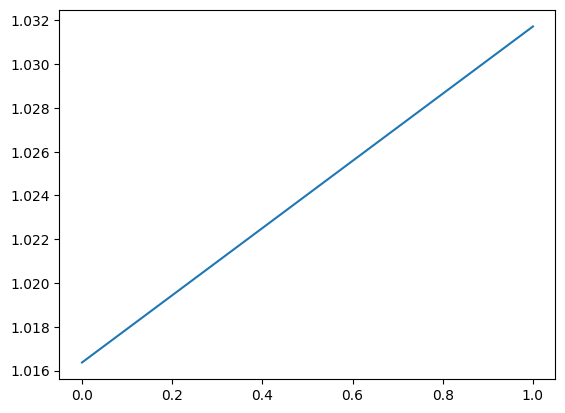

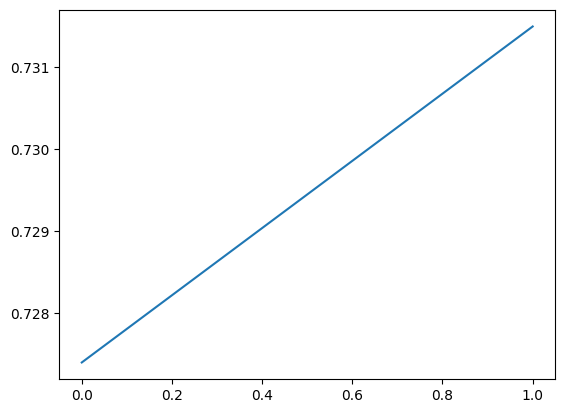

In [10]:
import matplotlib.pyplot as plt


#plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.show()    
#plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()    

In [12]:
from qkeras.utils import model_save_quantized_weights, load_qmodel


dic = model_save_quantized_weights(qmodel2, "qmodels/vgg16/qmodel_weights")
dic = model_save_quantized_weights(qmodel2, "qmodels/vgg16/qmodel_weights.h5")
qmodel2.save("qmodels/vgg16/model.h5")
qmodel_load_test = load_qmodel("qmodels/vgg16/model.h5", custom_objects={"ResNetPaperLR":ResNetPaperLR})
qmodel_load_test.evaluate(x_test, y_test)


... quantizing model
... quantizing model


c:\Users\georg\Desktop\mestrado_luiz\deep_nibble_dnn\.venv\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


313/313 [==============================] - 7s 19ms/step - loss: 1.0317 - accuracy: 0.7315


[1.0317189693450928, 0.7315000295639038]

In [13]:
print_qstats(qmodel2)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    conv2d                        : 1769472 (sadder_4_4)
    conv2d_1                      : 37748736 (sadder_4_4)
    conv2d_2                      : 18874368 (sadder_4_4)
    conv2d_3                      : 37748736 (sadder_4_4)
    conv2d_4                      : 18874368 (sadder_4_4)
    conv2d_5                      : 37748736 (sadder_4_4)
    conv2d_6                      : 37748736 (sadder_4_4)
    dense                         : 1048576 (sadder_4_4)
    dense_1                       : 65536 (sadder_4_4)
    dense_2                       : 2560  (sadder_4_4)

Number of operation types in model:
    sadder_4_4                    : 191629824

Weight profiling:
    conv2d_weights                 : 1728  (4-bit unit)
    conv2d_bias                    : 64    (4-bit unit)
    conv2d_1_weights               : 36864 (4-bit unit)
    conv2d_1_bias                  : 64    (4-bit unit)
    conv2d_2_weights               : 73728 (4-bit unit)
    conv2d_2_b